In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn import svm
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF, WhiteKernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from lolopy.learners import RandomForestRegressor as loRF

import torch
from torch import nn
import torch.nn.functional as func
from skorch import NeuralNetRegressor
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as r2
from keras.models import load_model

import uncertainty_toolbox as uct
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import norm

### 定义回归模型：
#### 高斯过程、神经网络、支持向量机、随机森林

In [2]:
def GP(x_train, x_test, y_train, y_test):
    print('---GuassionProcess---')
    scale_x = StandardScaler()
    x_train = scale_x.fit_transform(x_train)
    x_test = scale_x.transform(x_test)
    kernel = ExpSineSquared(length_scale=1.0,
                            periodicity=1.0,
                            length_scale_bounds=(1e-05, 1000000.0),
                            periodicity_bounds=(1e-05, 1000000.0),
                            ) + WhiteKernel()
    # kernel = RBF(length_scale=1, length_scale_bounds=(1e-7, 1e-5)) + WhiteKernel()

    gpr = GaussianProcessRegressor(kernel=kernel,
                                   normalize_y=True,
                                   n_restarts_optimizer=1000,
                                   alpha=0.01)
    gpr.fit(x_train, y_train)
    gpr.score(x_train, y_train)

    pred_test, std_test = gpr.predict(x_test, return_std=True)
    pred_train, std_train = gpr.predict(x_train, return_std=True)
    
    print('R2_test:', r2(y_test, pred_test))
    print('MAE_test:', mae(y_test, pred_test))
    print('RMSE_test:', mse(y_test, pred_test) ** 0.5)
    print('R2_train:', r2(y_train, pred_train))
    print('MAE_train:', mae(y_train, pred_train))
    print('RMSE_train:', mse(y_train, pred_train) ** 0.5)

    return pred_test, std_test, pred_train, std_train

class DropoutNN(nn.Module):  # 定义一个继承nn.Module的子类,自定义神经网络
    # 自定义构造函数
    def __init__(self):
        super(DropoutNN, self).__init__()  # 继承父类构造函数中的部分属性
        '''
        self.属性定义对应实例的属性
        Conv2d卷积层
        function.ReLU激活函数层
        function.MaxPool2d池化层
        Linear线性层
        Dropout丢节点
        '''
        self.input = nn.Linear(33, 100)
        self.dense1 = nn.Linear(100, 200)
        self.dense2 = nn.Linear(200, 200)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(200, 1)

    # 覆写forward，定义向前传播的神经网络
    def forward(self, x, **kwargs):
        x = self.input(x)
        x = func.relu(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.dropout(x)
        output = func.relu(x)
        output = self.output(output)
        return output


def NN(x_train, x_test, y_train, y_test):
    pred_test = pd.DataFrame(data=y_test.values, columns=['true'])
    pred_train = pd.DataFrame(data=y_train.values, columns=['true'])
    scaler_x = StandardScaler()
    X_train = scaler_x.fit_transform(x_train)
    X_train = X_train.astype(np.double)
    X_test = scaler_x.transform(x_test)
    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

    torch.set_default_tensor_type(torch.DoubleTensor)
    net = NeuralNetRegressor(
        DropoutNN,
        lr=0.02,
        max_epochs=2000,
        iterator_train__shuffle=True,
        warm_start=True,
        verbose=False,
    )

    for i in range(50):
        # resampling
        net.initialize()
        net.fit(X_train, y_train)
        pred_test[i + 1] = scaler_y.inverse_transform(net.predict(X_test))
        pred_train[i + 1] = scaler_y.inverse_transform(net.predict(X_train))
    pred_test['mean'] = pred_test.iloc[:, 1:].mean(axis=1)
    pred_test['std'] = pred_test.iloc[:, 1:].std(axis=1)
    pred_train['mean'] = pred_train.iloc[:, 1:].mean(axis=1)
    pred_train['std'] = pred_train.iloc[:, 1:].std(axis=1)
    
    
    print('---NN---')
    print('R2_test:', r2(pred_test['true'], pred_test['mean']))
    print('MAE_test:', mae(pred_test['true'], pred_test['mean']))
    print('RMSE_test:', mse(pred_test['true'], pred_test['mean']) ** 0.5)
    print('R2_train:', r2(pred_train['true'], pred_train['mean']))
    print('MAE_train:', mae(pred_train['true'], pred_train['mean']))
    print('RMSE_train:', mse(pred_train['true'], pred_train['mean']) ** 0.5)

    return pred_test['mean'], pred_test['std'], pred_train['mean'], pred_train['std']


def svr(x_train, x_test, y_train, y_test):
    print('---SVR---')
    scale_x = StandardScaler()
    x_train = scale_x.fit_transform(x_train)
    x_test = scale_x.transform(x_test)
    param_grid = [
        {'C': [0.5, 1, 1.5, 2, 3, 5, 10, 100, ],
         'kernel': ['linear', 'poly', 'rbf']}
    ]
    svm_reg = GridSearchCV(svm.SVR(), param_grid=param_grid, cv=5)

    svm_reg.fit(x_train, y_train.ravel())
    best_para = svm_reg.best_params_
    print(best_para)
    best_svr = svm.SVR(**best_para)
    pred_test = pd.DataFrame(data=y_test.values, columns=['true'])
    pred_train = pd.DataFrame(data=y_train.values, columns=['true'])
    for i in range(50):
        # resampling
        xtrain = resample(x_train, random_state=i)
        ytrain = resample(y_train, random_state=i)
        best_svr.fit(xtrain, ytrain.ravel())
        pred_test[i + 1] = best_svr.predict(x_test)
        pred_train[i + 1] = best_svr.predict(x_train)
    pred_test['mean'] = pred_test.iloc[:, 1:].mean(axis=1)
    pred_test['std'] = pred_test.iloc[:, 1:].std(axis=1)
    pred_train['mean'] = pred_train.iloc[:, 1:].mean(axis=1)
    pred_train['std'] = pred_train.iloc[:, 1:].std(axis=1)
    
    print('R2_test:', r2(pred_test['true'], pred_test['mean']))
    print('MAE_test:', mae(pred_test['true'], pred_test['mean']))
    print('RMSE_test:', mse(pred_test['true'], pred_test['mean']) ** 0.5)
    print('R2_train:', r2(pred_train['true'], pred_train['mean']))
    print('MAE_train:', mae(pred_train['true'], pred_train['mean']))
    print('RMSE_train:', mse(pred_train['true'], pred_train['mean']) ** 0.5)

    return pred_test['mean'], pred_test['std'], pred_train['mean'], pred_train['std']


def rf(x_train, x_test, y_train, y_test):
    print('---RF---')
    scale_x = StandardScaler()
    x_train = scale_x.fit_transform(x_train)
    x_test = scale_x.transform(x_test)
    best_rf = loRF()
    # param_grid = {
    #     'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    #     'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    #     # 'min_leaf_instances': [1, 2, 3, 4, 5],
    #     # 'random_seed': [123],
    # }
    # regressor = GridSearchCV(regressor, param_grid=param_grid, cv=5)

    best_rf.fit(x_train, y_train.ravel())
    # best_para = regressor.best_params_
    # print(best_para)
    # best_rf = loRF(**best_para).fit(x_train, y_train.ravel())
    feature_importances = best_rf.feature_importances_
    pred_test, std_test = best_rf.predict(x_test, return_std=True)
    pred_train, std_train = best_rf.predict(x_train, return_std=True)
    
    print('R2_test:', r2(y_test, pred_test))
    print('MAE_test:', mae(y_test, pred_test))
    print('RMSE_test:', mse(y_test, pred_test) ** 0.5)
    print('R2_train:', r2(y_train, pred_train))
    print('MAE_train:', mae(y_train, pred_train))
    print('RMSE_train:', mse(y_train, pred_train) ** 0.5)
    return pred_test, std_test, pred_train, std_train

# def rf(x_train, x_test, y_train, y_test):
#     print('---RF with Hyperparameter Search---')
#     scale_x = StandardScaler()
#     x_train = scale_x.fit_transform(x_train)
#     x_test = scale_x.transform(x_test)
    
#     # 定义超参数网格
#     param_grid = {
#         'n_estimators': [100, 200, 300, 400, 500],
#         'max_depth': [5, 10, 15, 20],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4],
#         'bootstrap': [True, False]
#     }

#     # 使用 GridSearchCV 寻找最佳参数
#     rf = RandomForestRegressor(random_state=123)
#     grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
#     grid_search.fit(x_train, y_train.ravel())
#     best_params = grid_search.best_params_
#     print("Best parameters found by GridSearchCV:", best_params)
    
#     # 使用最佳参数创建随机森林模型
#     best_rf = RandomForestRegressor(**best_params)
    
#     # 初始化结果数据框
#     pred_test = pd.DataFrame(data=y_test.values, columns=['true'])
#     pred_train = pd.DataFrame(data=y_train.values, columns=['true'])
    
#     for i in range(50):
#         # 重采样训练数据
#         xtrain_resampled, ytrain_resampled = resample(x_train, y_train, random_state=i)
        
#         # 在重采样数据上训练模型
#         best_rf.fit(xtrain_resampled, ytrain_resampled.ravel())
        
#         # 对测试集和训练集进行预测
#         pred_test[f'pred_{i+1}'] = best_rf.predict(x_test)
#         pred_train[f'pred_{i+1}'] = best_rf.predict(x_train)
    
#     # 计算预测结果的均值和标准差
#     pred_test['mean'] = pred_test.iloc[:, 1:].mean(axis=1)
#     pred_test['std'] = pred_test.iloc[:, 1:].std(axis=1)
#     pred_train['mean'] = pred_train.iloc[:, 1:].mean(axis=1)
#     pred_train['std'] = pred_train.iloc[:, 1:].std(axis=1)
    
#     # 输出模型评估指标
#     print('R2_test:', r2(pred_test['true'], pred_test['mean']))
#     print('MAE_test:', mae(pred_test['true'], pred_test['mean']))
#     print('RMSE_test:', mse(pred_test['true'], pred_test['mean']) ** 0.5)
#     print('R2_train:', r2(pred_train['true'], pred_train['mean']))
#     print('MAE_train:', mae(pred_train['true'], pred_train['mean']))
#     print('RMSE_train:', mse(pred_train['true'], pred_train['mean']) ** 0.5)
    
#     return pred_test['mean'], pred_test['std'], pred_train['mean'], pred_train['std']

def xgboost(x_train, x_test, y_train, y_test):
    print('---XGBoost---')
    scale_x = StandardScaler()
    x_train = scale_x.fit_transform(x_train)
    x_test = scale_x.transform(x_test)
    
    param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }

    xgb_reg = GridSearchCV(xgb.XGBRegressor(), param_grid=param_grid, cv=5, n_jobs=-1)
    xgb_reg.fit(x_train, y_train.ravel())
    best_para = xgb_reg.best_params_
    print("Best parameters:", best_para)
    
    best_xgb = xgb.XGBRegressor(**best_para)
    pred_test = pd.DataFrame(data=y_test.values, columns=['true'])
    pred_train = pd.DataFrame(data=y_train.values, columns=['true'])
    
    for i in range(50):
        # Resampling
        xtrain_resampled, ytrain_resampled = resample(x_train, y_train, random_state=i)
        best_xgb.fit(xtrain_resampled, ytrain_resampled.ravel())
        pred_test[i + 1] = best_xgb.predict(x_test)
        pred_train[i + 1] = best_xgb.predict(x_train)
    
    pred_test['mean'] = pred_test.iloc[:, 1:].mean(axis=1)
    pred_test['std'] = pred_test.iloc[:, 1:].std(axis=1)
    pred_train['mean'] = pred_train.iloc[:, 1:].mean(axis=1)
    pred_train['std'] = pred_train.iloc[:, 1:].std(axis=1)
    
    print('R2_test:', r2(pred_test['true'], pred_test['mean']))
    print('MAE_test:', mae(pred_test['true'], pred_test['mean']))
    print('RMSE_test:', mse(pred_test['true'], pred_test['mean']) ** 0.5)
    print('R2_train:', r2(pred_train['true'], pred_train['mean']))
    print('MAE_train:', mae(pred_train['true'], pred_train['mean']))
    print('RMSE_train:', mse(pred_train['true'], pred_train['mean']) ** 0.5)

    return pred_test['mean'], pred_test['std'], pred_train['mean'], pred_train['std']

def gbt(x_train, x_test, y_train, y_test):
    print('---Gradient Boosting Trees (GBT)---')
    scale_x = StandardScaler()
    x_train = scale_x.fit_transform(x_train)
    x_test = scale_x.transform(x_test)
    
    param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9],
    }

    gbt_reg = GridSearchCV(GradientBoostingRegressor(), param_grid=param_grid, cv=5, n_jobs=-1)
    gbt_reg.fit(x_train, y_train.ravel())
    best_para = gbt_reg.best_params_
    print("Best parameters:", best_para)
    
    best_gbt = GradientBoostingRegressor(**best_para)
    pred_test = pd.DataFrame(data=y_test.values, columns=['true'])
    pred_train = pd.DataFrame(data=y_train.values, columns=['true'])
    
    for i in range(50):
        # Resampling
        xtrain_resampled, ytrain_resampled = resample(x_train, y_train, random_state=i)
        best_gbt.fit(xtrain_resampled, ytrain_resampled.ravel())
        pred_test[i + 1] = best_gbt.predict(x_test)
        pred_train[i + 1] = best_gbt.predict(x_train)
    
    pred_test['mean'] = pred_test.iloc[:, 1:].mean(axis=1)
    pred_test['std'] = pred_test.iloc[:, 1:].std(axis=1)
    pred_train['mean'] = pred_train.iloc[:, 1:].mean(axis=1)
    pred_train['std'] = pred_train.iloc[:, 1:].std(axis=1)
    
    print('R2_test:', r2(pred_test['true'], pred_test['mean']))
    print('MAE_test:', mae(pred_test['true'], pred_test['mean']))
    print('RMSE_test:', mse(pred_test['true'], pred_test['mean']) ** 0.5)
    print('R2_train:', r2(pred_train['true'], pred_train['mean']))
    print('MAE_train:', mae(pred_train['true'], pred_train['mean']))
    print('RMSE_train:', mse(pred_train['true'], pred_train['mean']) ** 0.5)

    return pred_test['mean'], pred_test['std'], pred_train['mean'], pred_train['std']

### 绘图

In [3]:
# 统一设置全局字体和字号
matplotlib.rcParams.update({
    'font.family': 'Arial',     # 设置全局字体为Arial
    'font.size': 30,            # 设置全局字体大小
    'axes.labelsize': 30,       # 设置坐标轴标签字体大小
    'xtick.labelsize': 27,      # 设置x轴刻度字体大小
    'ytick.labelsize': 27,      # 设置y轴刻度字体大小
    'legend.fontsize': 27,      # 设置图例字体大小
})

# 统一绘图风格函数
def set_plot_style(axes, fs=30, bwith=2, x_minor=50, y_minor=20):
    """
    统一设置绘图风格
    """
    # 设置字体为Arial
    matplotlib.rcParams['font.family'] = 'Arial'
    matplotlib.rcParams['font.sans-serif'] = ['Arial']
    
    # 设置边框宽度
    axes.spines['bottom'].set_linewidth(bwith)
    axes.spines['left'].set_linewidth(bwith)
    axes.spines['top'].set_linewidth(bwith)
    axes.spines['right'].set_linewidth(bwith)
    
    # 设置刻度
    axes.xaxis.set_minor_locator(plt.MultipleLocator(x_minor))
    axes.yaxis.set_minor_locator(plt.MultipleLocator(y_minor))
    axes.tick_params(direction='in', length=7, width=2, labelsize=fs * 0.8, grid_alpha=1)
    
    # 设置标题和坐标轴标签的字体大小
    axes.set_title(axes.get_title(), fontsize=fs)  # 设置标题字体大小
    axes.set_xlabel(axes.get_xlabel(), fontsize=fs)  # 设置x轴标签字体大小
    axes.set_ylabel(axes.get_ylabel(), fontsize=fs)  # 设置y轴标签字体大小

    # 设置图例字体大小
    legend = axes.get_legend()
    if legend is not None:
        plt.setp(legend.get_texts(), fontsize=fs * 0.8)  # 图例字体大小为 0.8 * fs
    for text in axes.texts:
        text.set_fontsize(fs * 0.8)
        
def save_and_show_plot(title):
    # 保存高分辨率图像
    plt.savefig(title, dpi=500, bbox_inches='tight')
    plt.show()

# 绘制预测值与真实值对比
def plt_true_vs_pred(y_train, y_test, pred_train, pred_test, std_train, std_test, savename, lim=(-1, 13)):
    fig, axes = plt.subplots(1, 1, figsize=(8, 8))
    fs = 30

    # 绘制校准线
    axes.plot(lim, lim, 'r--', alpha=1, zorder=0, c='black')

    axes.scatter(y_train, pred_train, alpha=1, c="#1f77b4", label='Train', s=80)
    axes.errorbar(y_train, pred_train, alpha=1, fmt='o', c="#1f77b4", yerr=std_train, elinewidth=1, capsize=2, capthick=1, barsabove=True)

    # 绘制测试集数据，使用Nature风格的橙色
    axes.scatter(y_test, pred_test, alpha=1, c='#ff7f0e', label='Test', s=80)
    axes.errorbar(y_test, pred_test, alpha=1, fmt='o', c='#ff7f0e', yerr=std_test, elinewidth=1, capsize=2, capthick=1, barsabove=True)

    # 设置标题和标签
    axes.set_xlabel('lg(Measured creep rupture life)(h)', fontsize=fs)
    axes.set_ylabel('lg(Predicted creep rupture life)(h)', fontsize=fs)
    axes.set_title(savename, fontsize=fs)
    plt.legend(loc='upper left', frameon=False, fontsize=0.8*fs)

    # 应用统一样式
    set_plot_style(axes, fs)

    # 设置坐标轴的范围
    axes.set_xlim(lim)
    axes.set_ylim(lim)

    # 保存和显示图形
    save_and_show_plot(savename)

# 绘制残差分布
def plot_residual_distribution(calibrated_df, uncalibrated_df, title):
    """
    绘制标准化残差的直方图，并保存和显示图形。
    """
    # 计算校准前后的残差
    uncalibrated_df['residual'] = uncalibrated_df['true'] - uncalibrated_df['mean']
    uncalibrated_df['r_uncalibrated'] = uncalibrated_df['residual'] / uncalibrated_df['std']

    calibrated_df['residual'] = calibrated_df['true'] - calibrated_df['mean']
    calibrated_df['r_calibrated'] = calibrated_df['residual'] / calibrated_df['std']

    # 创建图形
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))
    fs = 30  # 字体大小

    # 绘制未校准残差直方图
    sns.histplot(uncalibrated_df['r_uncalibrated'], bins=20, stat="density", label='uncalibrated', color='gray')

    # 绘制校准残差直方图
    sns.histplot(calibrated_df['r_calibrated'], bins=20, stat="density", label='calibrated', color='blue', alpha=1)

    # 绘制标准正态分布作为参考
    x = np.linspace(-10, 10, 100)
    plt.plot(x, norm.pdf(x), label='standard normal pdf', color='orange')

    # 设置标题和图例
    plt.title(title, fontsize=fs)
    plt.legend(frameon=False, fontsize=0.8*fs)

    # 修改横纵坐标标签
    plt.ylabel('Relative counts', fontsize=fs)
    plt.xlabel('Residuals / $\hat{\sigma}$', fontsize=fs)

    # 应用统一风格
    set_plot_style(axes, fs)

    # 保存和显示图形
    save_and_show_plot(title + '_hist')

def error_based(rmv, rmse, rmv_new, rmse_new, title):
    """
    根据rmse, rmv指标绘图，添加两组数据，分别使用不同颜色，并拟合一条短线
    """
    fig, axes = plt.subplots(1, 1, figsize=(8, 8))
    fs = 30

    # 第一个散点图，使用浅灰色，并添加黑色边框
    axes.scatter(rmv, rmse, alpha=1, c="lightgray", edgecolor="black", s=150, label="Uncalibrated")  
    # 第二个散点图，使用黄色，并添加黑色边框
    axes.scatter(rmv_new, rmse_new, alpha=1, c="blue", edgecolor="black", s=150, label="Calibrated")  

    # 对第一个数据集进行线性拟合，拟合一条短直线
    model = LinearRegression()

    model.fit(np.array(rmv).reshape(-1, 1), np.array(rmse).reshape(-1, 1))
    
    # 获取拟合直线的起点和终点
    x_fit = np.linspace(min(rmv)-0.1, max(rmv)+0.1, 100)
    y_fit = model.predict(x_fit.reshape(-1, 1))

    # 在第一个数据集的散点中绘制拟合的短直线
    axes.plot(x_fit, y_fit, '#696969', lw=2, label="Fitted Line")

    # 计算动态范围
    x_min, x_max = min(min(rmv), min(rmv_new)) - 0.5, max(max(rmv), max(rmv_new)) + 0.5
    y_min, y_max = min(min(rmse), min(rmse_new)) - 0.5, max(max(rmse), max(rmse_new)) + 0.5

    # 绘制校准线（对角线）
    lims = [min(x_min, y_min), max(x_max, y_max)]  # 取 x 和 y 的最小值和最大值，确保图像范围足够
    axes.plot(lims, lims, 'k--', alpha=1, zorder=0, c='blue')  # 蓝色校准线

    # 设置坐标范围为动态范围
    axes.set_xlim(lims)
    axes.set_ylim(lims)

    # 设置坐标标签
    axes.set_xlabel('RMV', fontsize=fs)
    axes.set_ylabel('RMSE', fontsize=fs)

    # 添加图例
    axes.legend(loc='upper left', fontsize=16, frameon=False)

    # 应用统一风格
    set_plot_style(axes, fs)

    # 保存和显示图形
    save_and_show_plot(title + '_error')


# 生成校准图的风格化版本
def plot_calibration_style(mean, std, true, savename):
    fig, axes = plt.subplots(1, 1, figsize=(8, 8))
    
    # 调用校准绘图函数
    uct.viz.plot_calibration(mean, std, true, ax=axes)
    axes.set_title('')  # 移除标题
    
    # 修改填充区域的颜色
    for collection in axes.collections:
        collection.set_color("blue")  # 设置灰蓝色填充区域

    # 修改对角线和绘制的线段颜色
    for line in axes.lines:
        if np.array_equal(line.get_xdata(), [0, 1]) and np.array_equal(line.get_ydata(), [0, 1]):
            line.set_color("black")  # 橙色作为对角线颜色
        else:
            line.set_color("#1F77B4")  # 深蓝色作为校准/预测线颜色

    # 应用统一样式
    set_plot_style(axes, fs=30)
    
    # 保存高分辨率图片
    save_and_show_plot(savename)

# 生成锐度图的风格化版本
def plot_sharpness_style(std, savename):
    fig, axes = plt.subplots(1, 1, figsize=(8, 8))
    
    # 调用锐度绘图函数
    uct.viz.plot_sharpness(std, ax=axes)
    axes.set_title('')  # 移除标题
    
    # 修改填充区域的颜色
    for collection in axes.collections:
        collection.set_color("#A6CEE3")  # 设置灰蓝色填充区域

    # 修改绘制的线段颜色为深蓝色
    for line in axes.lines:
        line.set_color("#1F77B4")  # 深蓝色作为线段颜色

    # 应用统一样式
    set_plot_style(axes, fs=30)
    
    # 保存高分辨率图片
    save_and_show_plot(savename)
    
def cv(data):
    """
    计算变异系数
    :param data: dataframe of result with columns=['true','mean','std']
    :return:
    """
    n = data.shape[0]
    x = 0
    m = data['std'].mean()
    for i in range(n):
        k = data.loc[i, 'std'] - m
        x = x + pow(k, 2)
    x = pow(x, 0.5)
    return x / m


def scc(result):
    """
    绝对误差与不确定性的斯皮尔曼系数
    """
    result['error'] = abs(result['true']-result['mean'])
    coef = result.corr(method='spearman')
    return coef.loc['error', 'std']


def rmse_rmv(result):
    result = result.sort_values(by='std')  # 按不确定性排序
    result['var'] = result['std'].apply(lambda x: x*x)
    n = result.shape[0]
    n_bin = 20 #可调参数：分组数量
    len_bin = int(n / n_bin) + 1
    rmse = []
    rmv = []
    ence = 0
    for i in range(0, n, len_bin): # 计算每个bin的rmse和rmv 
        rmv_i = result['var'][i:i + len_bin].mean() ** 0.5
        rmse_i = mse(result['true'][i:i + n_bin], result['mean'][i:i + n_bin]) ** 0.5
        ence += abs(rmv_i - rmse_i) / rmv_i
        rmse += [rmse_i]
        rmv += [rmv_i]
    ence = ence / n_bin
    return rmse, rmv, ence


# def error_based(rmv, rmse, title):
#     """
#     根据rmse, rmv指标绘图
#     """
#     fig, axes = plt.subplots(1, 1, figsize=(8, 8))
#     plt.rcParams['font.sans-serif']='Arial'
#     fs = 22
#     lims1 = (-1, 300)  # 校准线

#     axes.scatter(rmv, rmse, alpha=1, c="#1f77b4", s=50)
#     axes.plot(lims1, lims1, 'k--', alpha=1, zorder=0, c='orange')
#     axes.set_xlabel('RMV', fontsize=fs)
#     axes.set_ylabel('RMSE', fontsize=fs)
# #     axes.set_title(title, fontsize=fs)
#     axes.set_xlim(-1, 2)
#     axes.set_ylim(-1, 2)
#     axes.tick_params(direction='in', length=5, width=1, labelsize=fs * .8, grid_alpha=0.5)
#     bwith=1.5
#     axes.spines['bottom'].set_linewidth(bwith)
#     axes.spines['left'].set_linewidth(bwith)
#     axes.spines['top'].set_linewidth(bwith)
#     axes.spines['right'].set_linewidth(bwith)
# #     axes.grid(True, linestyle='-.')

#     plt.subplots_adjust(wspace=0.4)
#     plt.savefig(title + '_error.png', dpi=500, bbox_inches='tight')
#     plt.show()

#### 载入钛合金数据

In [4]:
df = pd.read_excel('data_S3.xlsx')
X = df.iloc[:, 1:34]
# print(X)
y = df['Creep rupture life (h)']
y = np.log(df['Creep rupture life (h)'])

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)
print(max(y_test),max(y_train))
print(min(y_test),min(y_train))
# 训练集特征归一化
# scale_x = StandardScaler()
# x_train = scale_x.fit_transform(x_train)
# x_test = scale_x.transform(x_test)


11.928578498805974 11.851940893507079
3.063390921093226 0.1823215567939546


### 随机森林

C:\Users\22175\AppData\Local\Temp\ipykernel_31584\1866113224.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  axes.plot(lim, lim, 'r--', alpha=1, zorder=0, c='black')


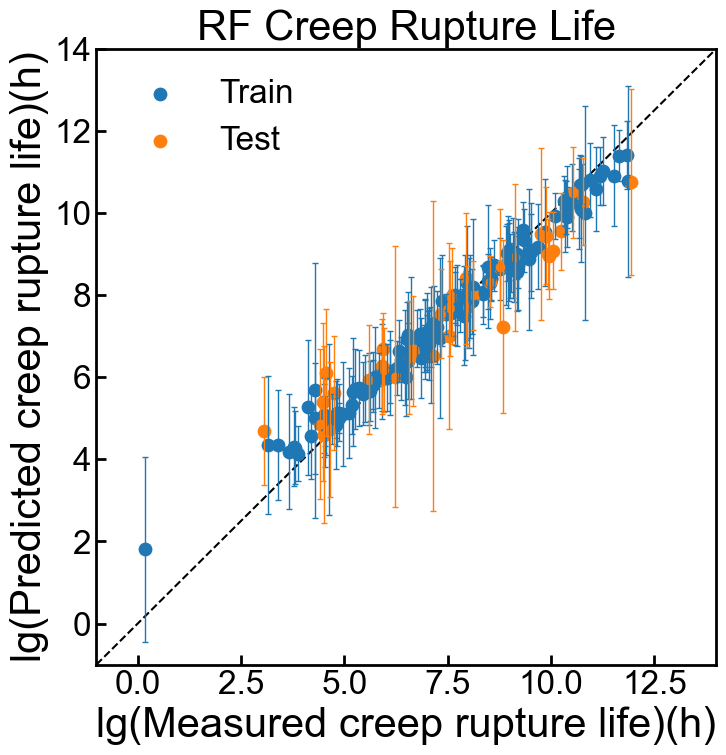

cv: 6.631310621623338
scc: 0.46354487764855307


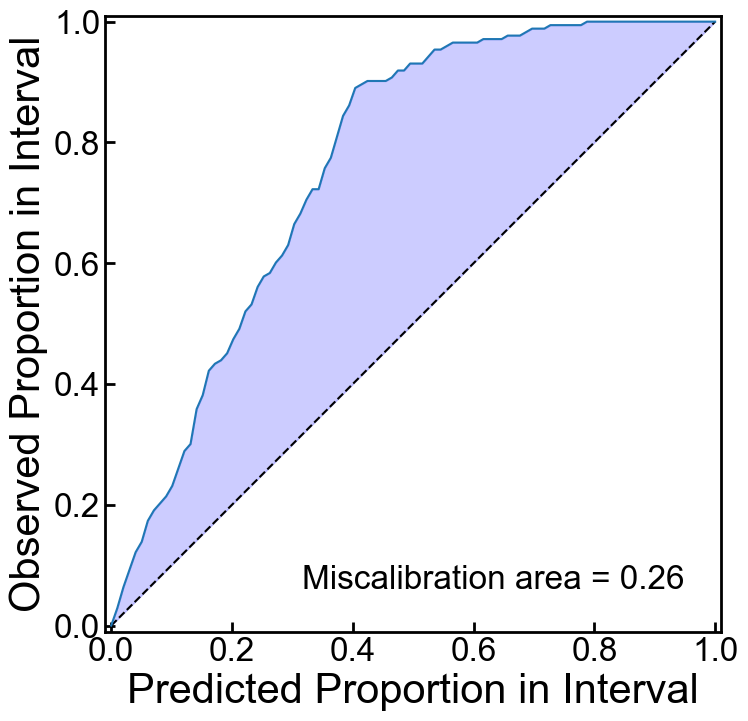

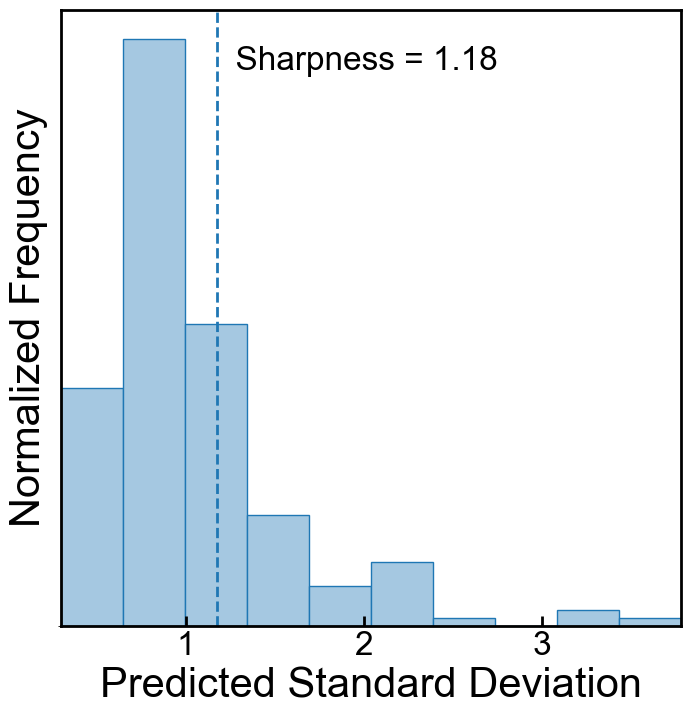

ence: 0.606934754566691


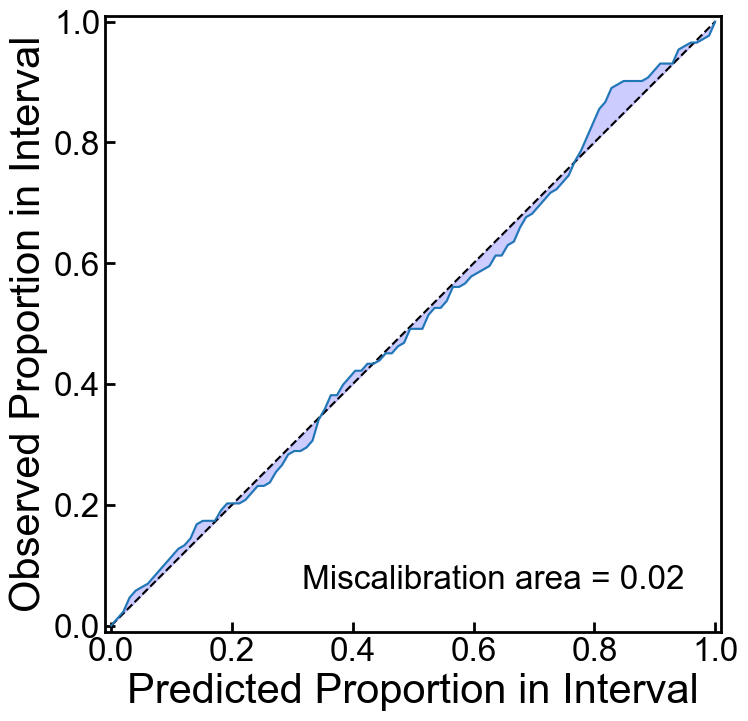

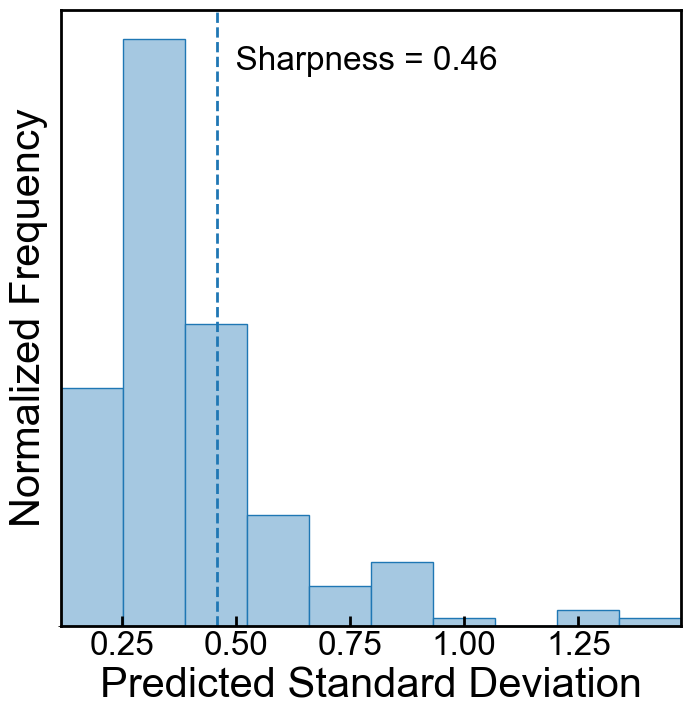

cv: 6.63131062162334
scc: 0.46354487764855307
ence: 0.20812140992617195


C:\Users\22175\AppData\Local\Temp\ipykernel_31584\1866113224.py:149: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes.plot(lims, lims, 'k--', alpha=1, zorder=0, c='blue')  # 蓝色校准线


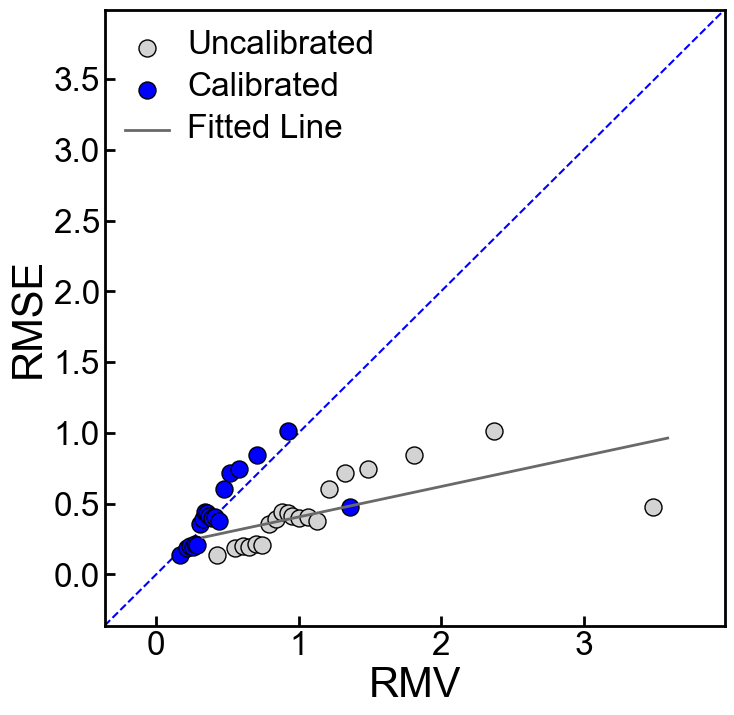

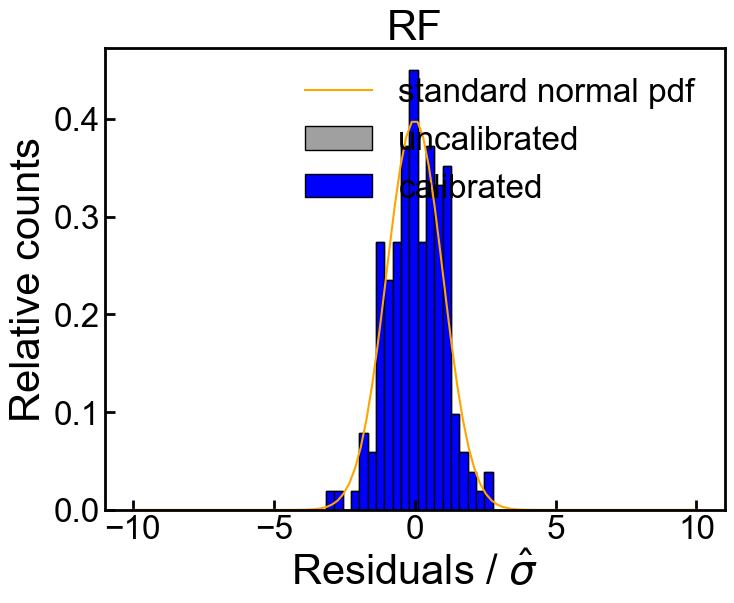

In [5]:
# pred_test, std_test, pred_train, std_train = rf(x_train, x_test, y_train, y_test)

# plt_true_vs_pred(y_train, y_test, pred_train, pred_test, std_train, std_test, savename='RF Creep Rupture Life', lim=(-1, 14))
# # print(type(pred_train))
# data = {'mean':list(pred_test)+list(pred_train),
#         'std':list(std_test)+list(std_train),
#         'true':list(y_test)+list(y_train) }
# result = pd.DataFrame(data)
# result_original = result
# # print(result)
# result.to_csv('result_SVR.csv')

result = pd.read_csv('result_RF.csv')
result_original = result

result_test = result.iloc[:len(x_test), :]
result_train = result.iloc[len(x_test):, :]

# 训练集的数据
y_train = result_train['true']
pred_train = result_train['mean']
std_train = result_train['std']

# 测试集的数据
y_test = result_test['true']
pred_test = result_test['mean']
std_test = result_test['std']

# print(y_train.shape, pred_train.shape)
plt_true_vs_pred(y_train, y_test, pred_train, pred_test, std_train, std_test, savename='RF Creep Rupture Life', lim=(-1, 14))

print('cv:', cv(result))
print('scc:', scc(result))

# 生成校准图
plot_calibration_style(np.array(result['mean']),
                         np.array(result['std']), 
                         np.array(result['true']),
                       'RF_cal_original.png')
# 生成sharpness图
plot_sharpness_style(np.array(result['std']), 'RF_sharp_original.png')

rmse, rmv, ence = rmse_rmv(result)
print('ence:',ence)

# 重校准后绘图
recalibrator = uct.recalibration.get_std_recalibrator(np.array(result['mean']),
                         np.array(result['std']), 
                         np.array(result['true']), criterion='rms_cal')
re_std = recalibrator(np.array(result['std']))
# # re_std = 0.55 * np.array(result['std'])
# # print(re_std)
result['std'] = re_std

plot_calibration_style(np.array(result['mean']),
                         re_std, 
                         np.array(result['true']),
                      'RF_recal.png')

plot_sharpness_style(re_std, 'RF_reshap.png')

# 打印结果
print('cv:', cv(result))
print('scc:', scc(result))

rmse_new, rmv_new, ence_new = rmse_rmv(result)
print('ence:',ence_new)
error_based(rmv, rmse, rmv_new, rmse_new, 'RF_re')
plot_residual_distribution(result_original, result, 'RF')

### 支持向量机

C:\Users\22175\AppData\Local\Temp\ipykernel_31584\1866113224.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  axes.plot(lim, lim, 'r--', alpha=1, zorder=0, c='black')


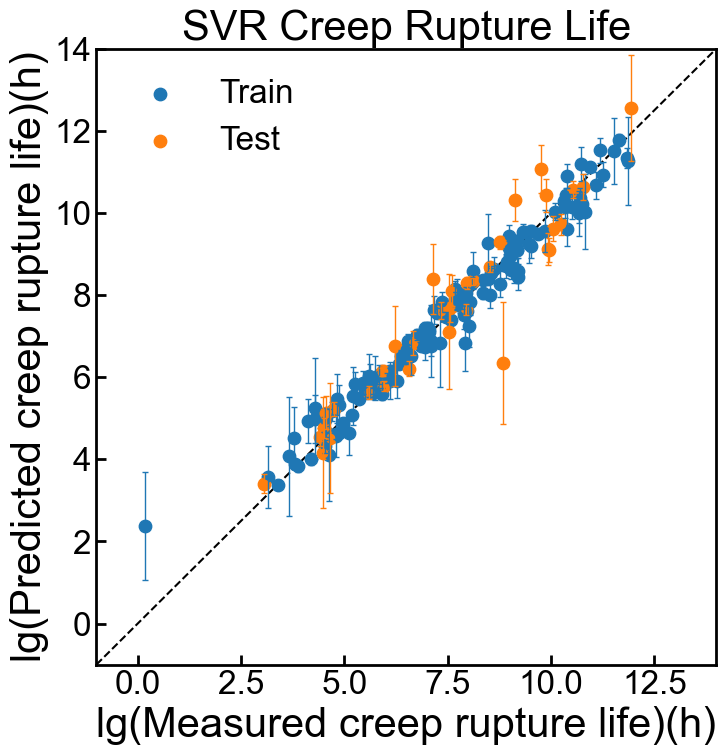

cv: 12.080914102472793
scc: 0.6666496701911176


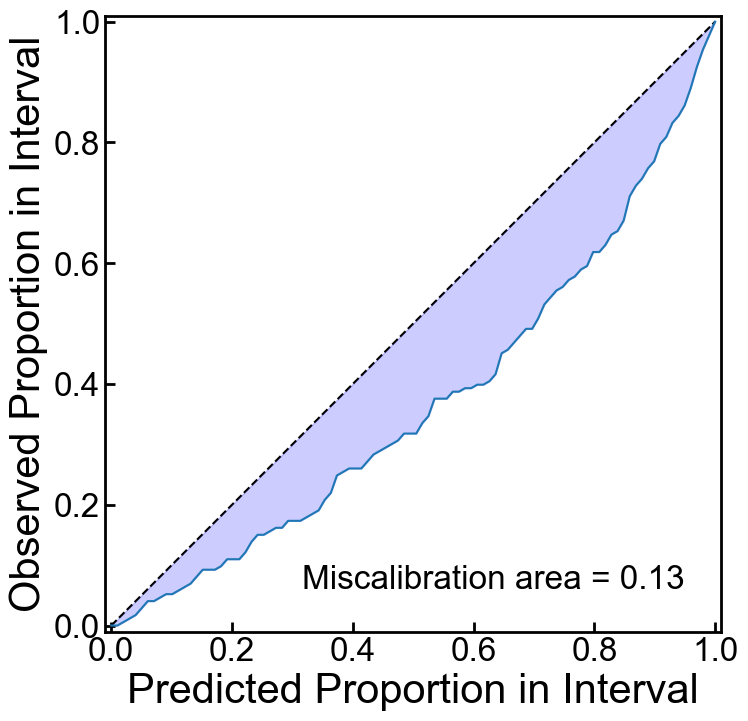

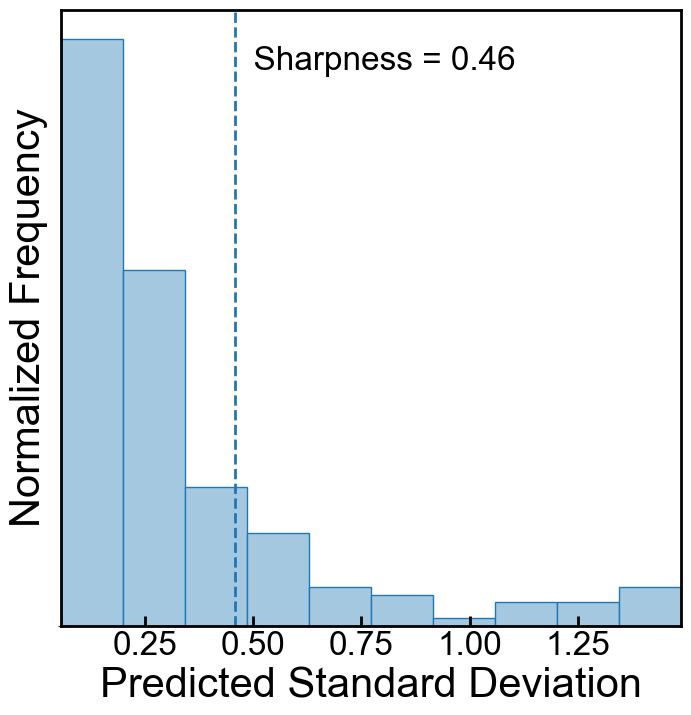

ence: 0.3984718679196335


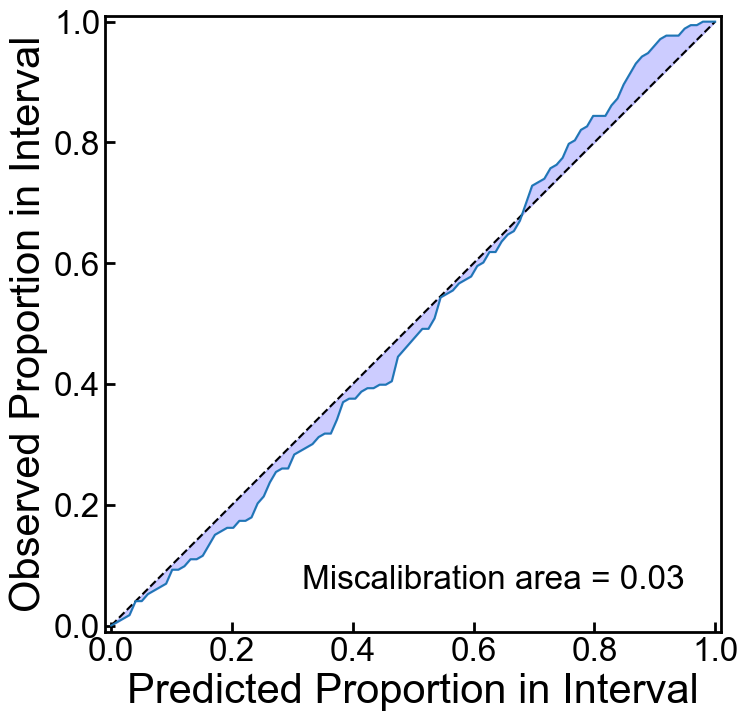

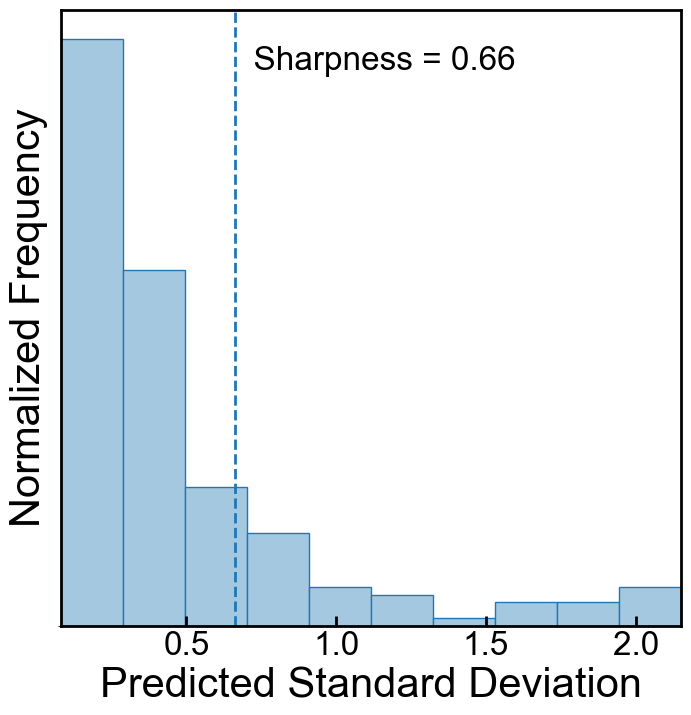

cv: 12.080914102472795
scc: 0.6666496701911176
ence: 0.08179064619220462


C:\Users\22175\AppData\Local\Temp\ipykernel_31584\1866113224.py:149: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes.plot(lims, lims, 'k--', alpha=1, zorder=0, c='blue')  # 蓝色校准线


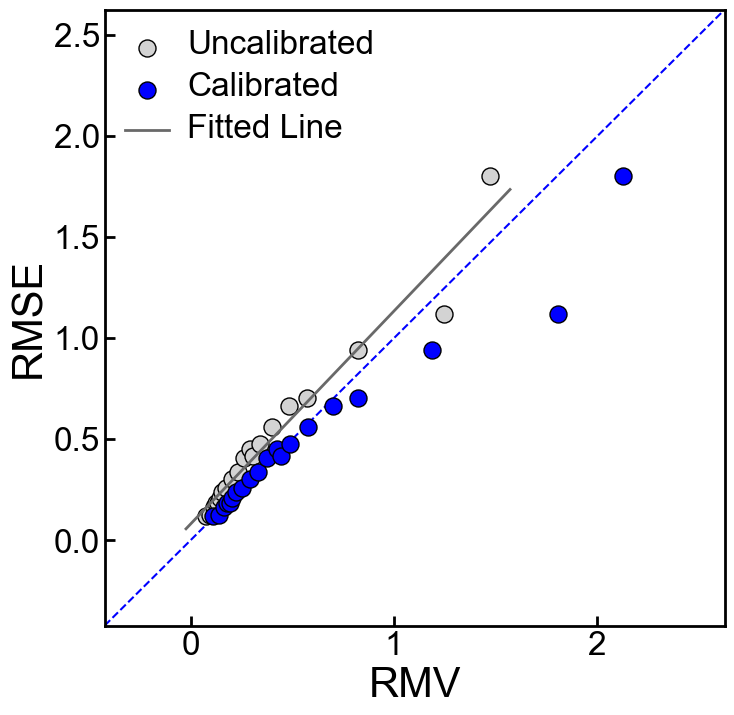

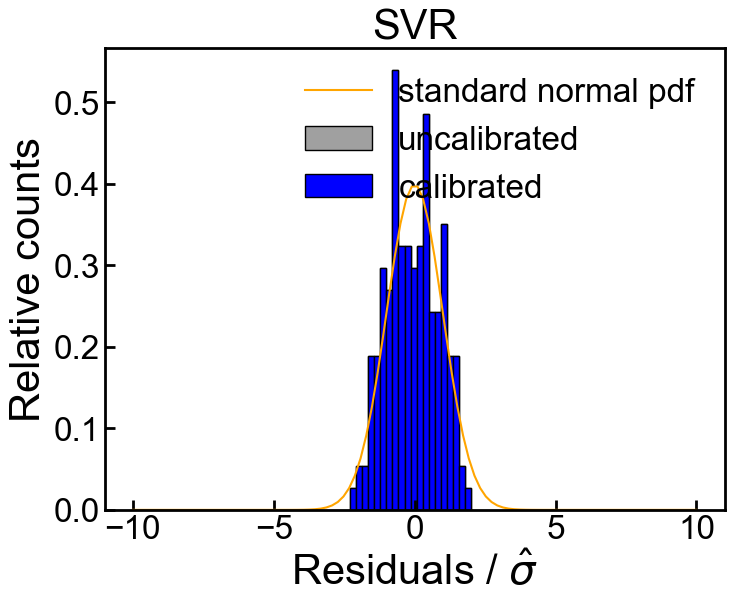

In [6]:
# pred_test, std_test, pred_train, std_train = SVR(x_train, x_test, y_train, y_test)

# plt_true_vs_pred(y_train, y_test, pred_train, pred_test, std_train, std_test, savename='SVR Creep Rupture Life', lim=(-1, 14))
# # print(type(pred_train))
# data = {'mean':list(pred_test)+list(pred_train),
#         'std':list(std_test)+list(std_train),
#         'true':list(y_test)+list(y_train) }
# result = pd.DataFrame(data)
# result_original = result
# # print(result)
# result.to_csv('result_SVR.csv')

result = pd.read_csv('result_SVR.csv')
result_original = result

result_test = result.iloc[:len(x_test), :]
result_train = result.iloc[len(x_test):, :]

# 训练集的数据
y_train = result_train['true']
pred_train = result_train['mean']
std_train = result_train['std']

# 测试集的数据
y_test = result_test['true']
pred_test = result_test['mean']
std_test = result_test['std']

# print(y_train.shape, pred_train.shape)
plt_true_vs_pred(y_train, y_test, pred_train, pred_test, std_train, std_test, savename='SVR Creep Rupture Life', lim=(-1, 14))

print('cv:', cv(result))
print('scc:', scc(result))

# 生成校准图
plot_calibration_style(np.array(result['mean']),
                         np.array(result['std']), 
                         np.array(result['true']),
                       'SVR_cal_original.png')
# 生成sharpness图
plot_sharpness_style(np.array(result['std']), 'SVR_sharp_original.png')

rmse, rmv, ence = rmse_rmv(result)
print('ence:',ence)

# 重校准后绘图
recalibrator = uct.recalibration.get_std_recalibrator(np.array(result['mean']),
                         np.array(result['std']), 
                         np.array(result['true']), criterion='rms_cal')
re_std = recalibrator(np.array(result['std']))
# # re_std = 0.55 * np.array(result['std'])
# # print(re_std)
result['std'] = re_std

plot_calibration_style(np.array(result['mean']),
                         re_std, 
                         np.array(result['true']),
                      'SVR_recal.png')

plot_sharpness_style(re_std, 'SVR_reshap.png')

# 打印结果
print('cv:', cv(result))
print('scc:', scc(result))

rmse_new, rmv_new, ence_new = rmse_rmv(result)
print('ence:',ence_new)
error_based(rmv, rmse, rmv_new, rmse_new, 'SVR_re')
plot_residual_distribution(result_original, result, 'SVR')

## XGBOOST

C:\Users\22175\AppData\Local\Temp\ipykernel_31584\1866113224.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  axes.plot(lim, lim, 'r--', alpha=1, zorder=0, c='black')


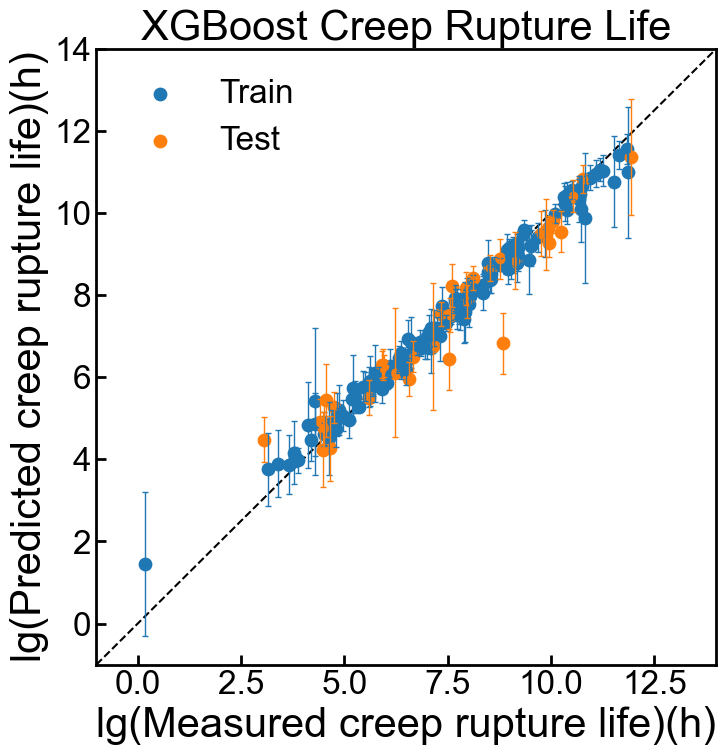

cv: 8.945470907618427
scc: 0.6749354520212673


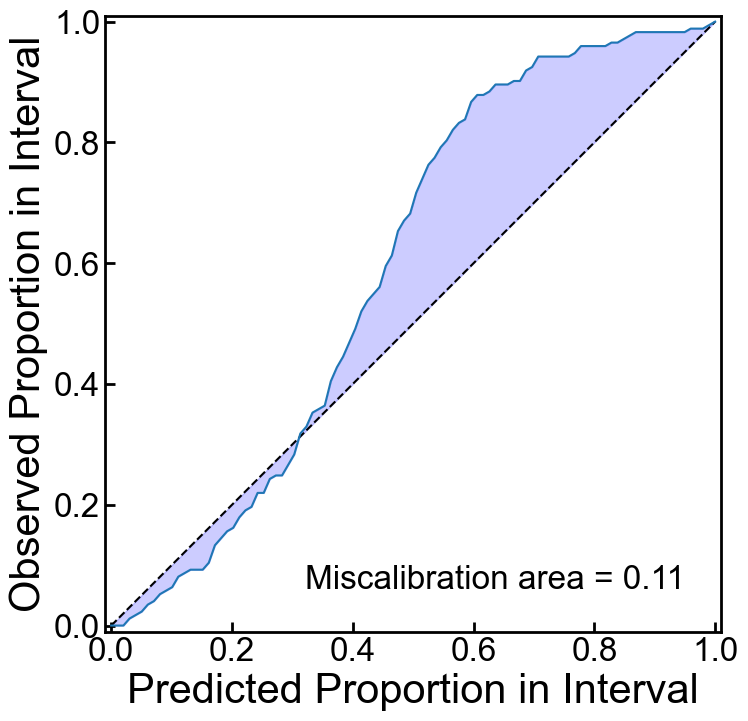

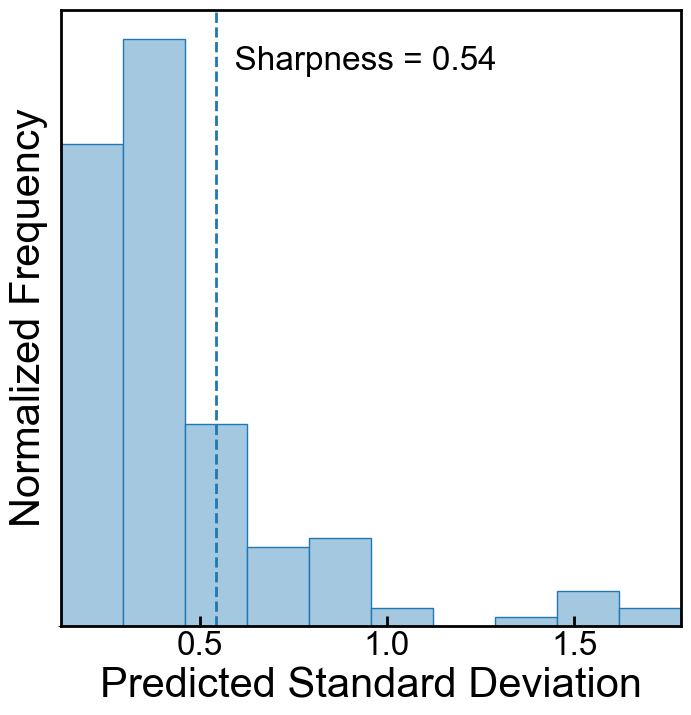

ence: 0.27147492912788296


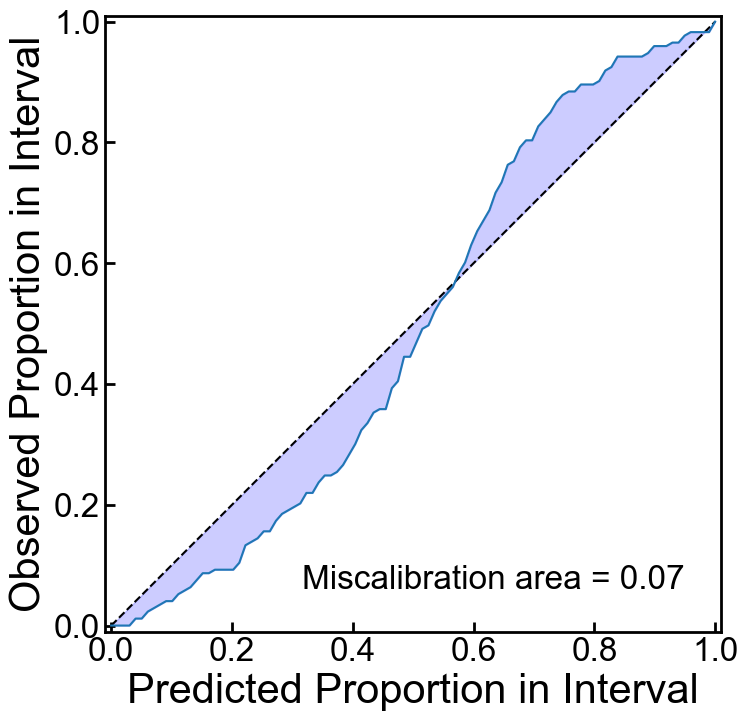

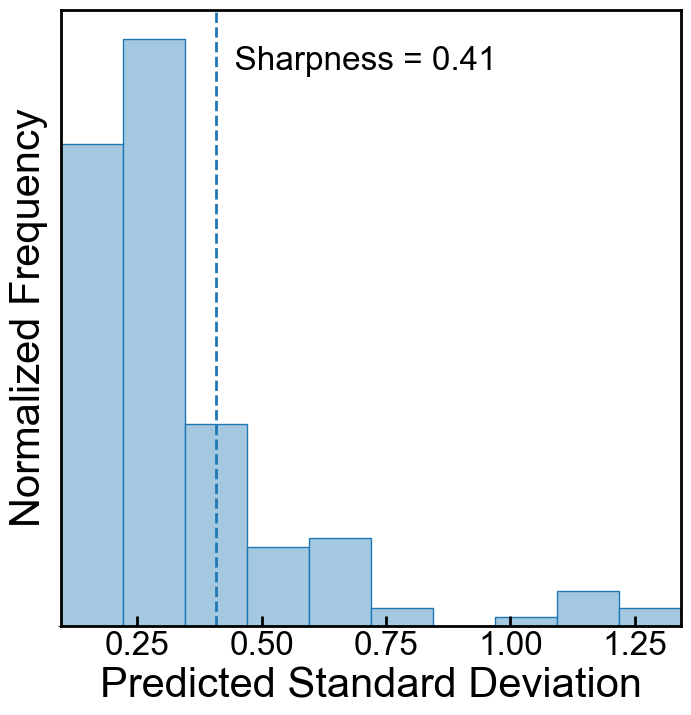

cv: 8.945470907618423
scc: 0.6749354520212673
ence: 0.16942844778362026


C:\Users\22175\AppData\Local\Temp\ipykernel_31584\1866113224.py:149: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes.plot(lims, lims, 'k--', alpha=1, zorder=0, c='blue')  # 蓝色校准线


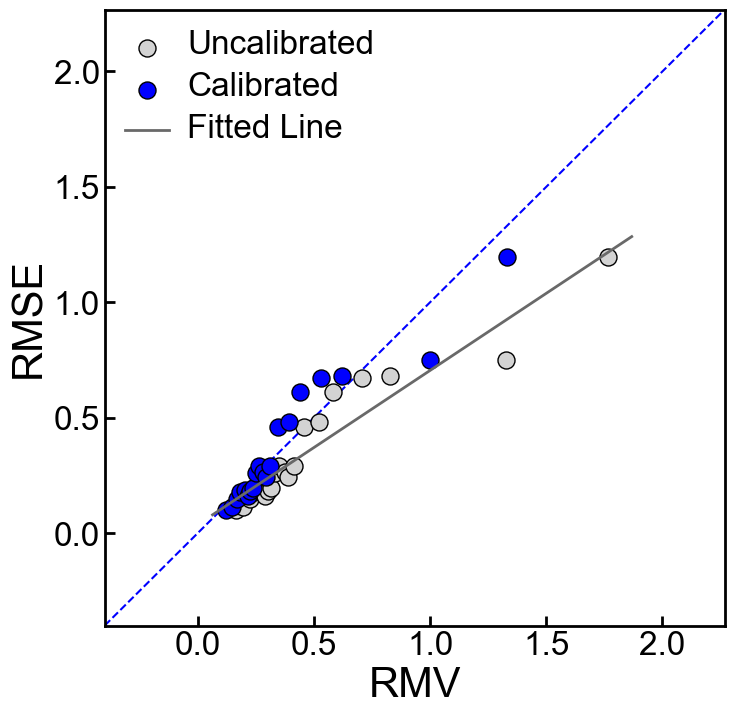

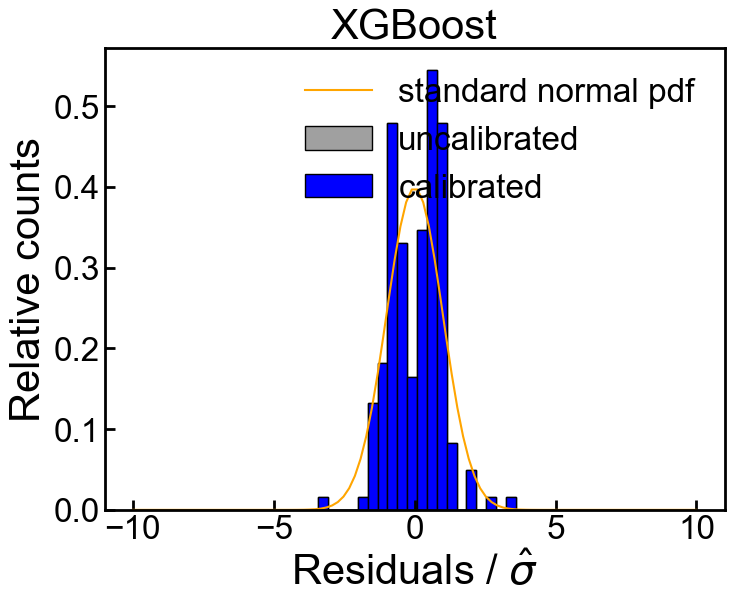

In [7]:
# pred_test, std_test, pred_train, std_train = XGBoost(x_train, x_test, y_train, y_test)

# plt_true_vs_pred(y_train, y_test, pred_train, pred_test, std_train, std_test, savename='XGBoost Creep Rupture Life', lim=(-1, 14))
# # print(type(pred_train))
# data = {'mean':list(pred_test)+list(pred_train),
#         'std':list(std_test)+list(std_train),
#         'true':list(y_test)+list(y_train) }
# result = pd.DataFrame(data)
# result_original = result
# # print(result)
# result.to_csv('result_XGBoost.csv')

result = pd.read_csv('result_XGBoost.csv')
result_original = result

result_test = result.iloc[:len(x_test), :]
result_train = result.iloc[len(x_test):, :]

# 训练集的数据
y_train = result_train['true']
pred_train = result_train['mean']
std_train = result_train['std']

# 测试集的数据
y_test = result_test['true']
pred_test = result_test['mean']
std_test = result_test['std']

# print(y_train.shape, pred_train.shape)
plt_true_vs_pred(y_train, y_test, pred_train, pred_test, std_train, std_test, savename='XGBoost Creep Rupture Life', lim=(-1, 14))

print('cv:', cv(result))
print('scc:', scc(result))

# 生成校准图
plot_calibration_style(np.array(result['mean']),
                         np.array(result['std']), 
                         np.array(result['true']),
                       'XGBoost_cal_original.png')
# 生成sharpness图
plot_sharpness_style(np.array(result['std']), 'XGBoost_sharp_original.png')

rmse, rmv, ence = rmse_rmv(result)
print('ence:',ence)

# 重校准后绘图
recalibrator = uct.recalibration.get_std_recalibrator(np.array(result['mean']),
                         np.array(result['std']), 
                         np.array(result['true']), criterion='rms_cal')
re_std = recalibrator(np.array(result['std']))
# # re_std = 0.55 * np.array(result['std'])
# # print(re_std)
result['std'] = re_std

plot_calibration_style(np.array(result['mean']),
                         re_std, 
                         np.array(result['true']),
                      'XGBoost_recal.png')

plot_sharpness_style(re_std, 'XGBoost_reshap.png')

# 打印结果
print('cv:', cv(result))
print('scc:', scc(result))

rmse_new, rmv_new, ence_new = rmse_rmv(result)
print('ence:',ence_new)
error_based(rmv, rmse, rmv_new, rmse_new, 'XGBoost_re')
plot_residual_distribution(result_original, result, 'XGBoost')

## 神经网络

C:\Users\22175\AppData\Local\Temp\ipykernel_12528\3792742109.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  axes.plot(lim, lim, 'r--', alpha=0.75, zorder=0, c='black')


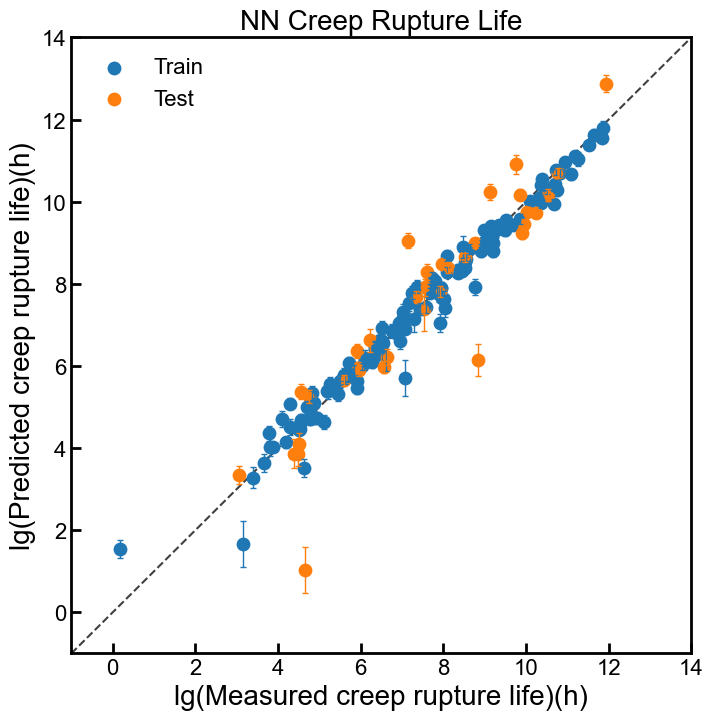

cv: 6.066757154810987
scc: 0.4977240174105715


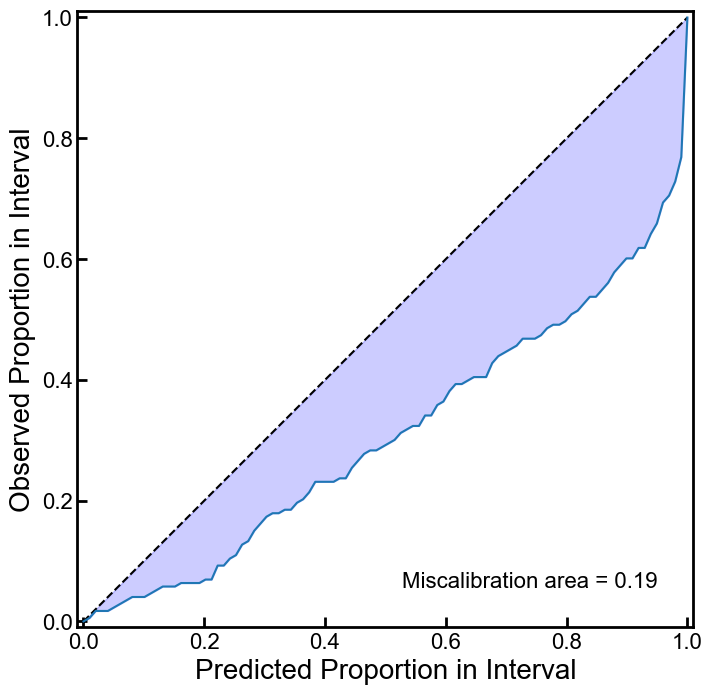

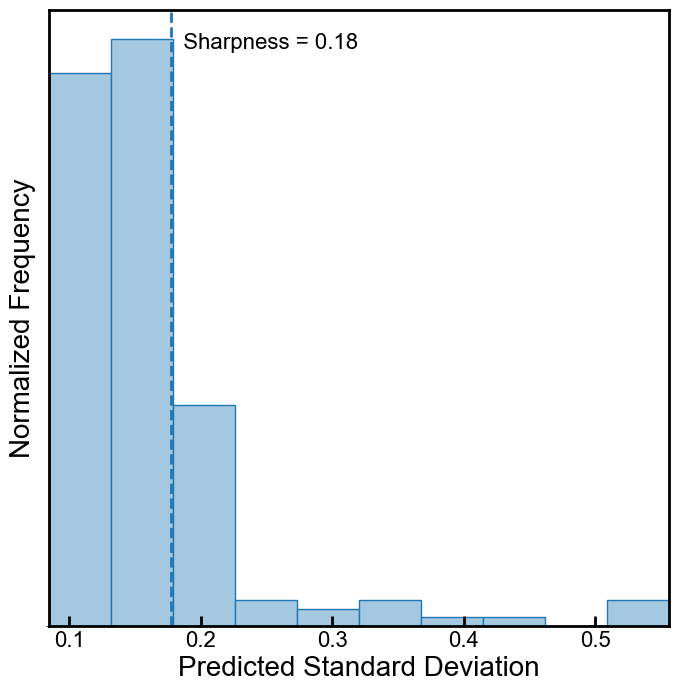

ence: 1.6071001267688405


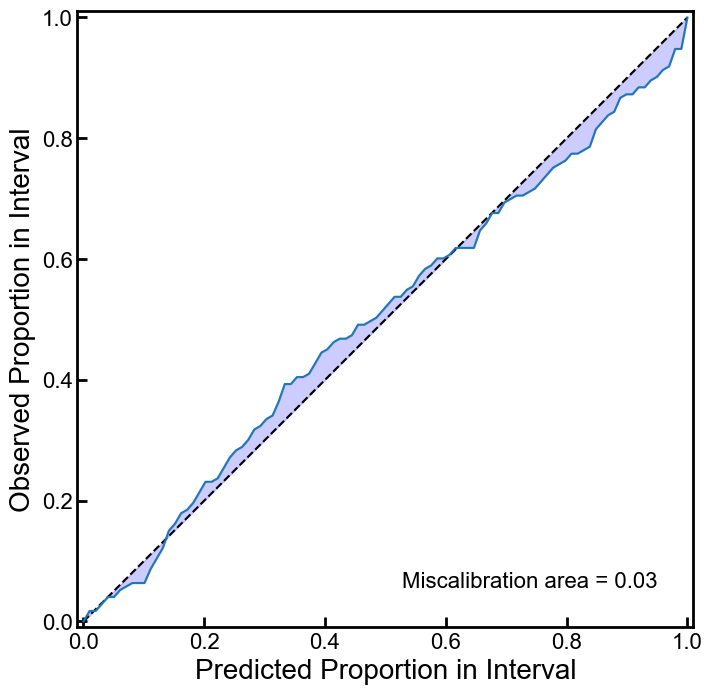

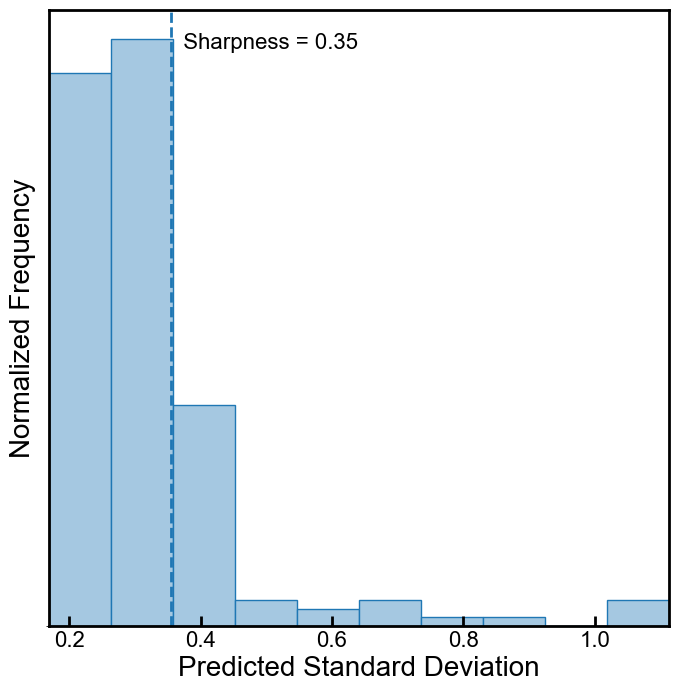

cv: 6.066757154810986
scc: 0.4977240174105715
ence: 0.4121116008681138


C:\Users\22175\AppData\Local\Temp\ipykernel_12528\3792742109.py:149: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes.plot(lims, lims, 'k--', alpha=1, zorder=0, c='blue')  # 蓝色校准线


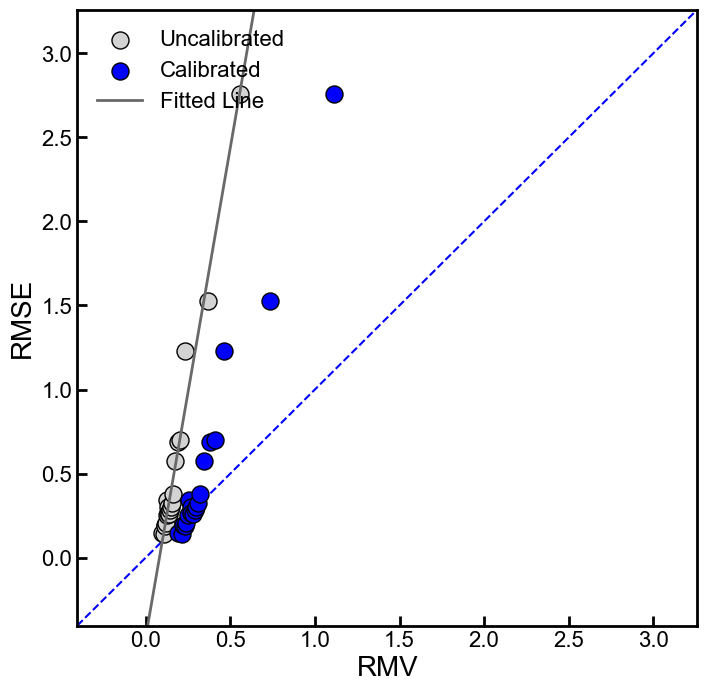

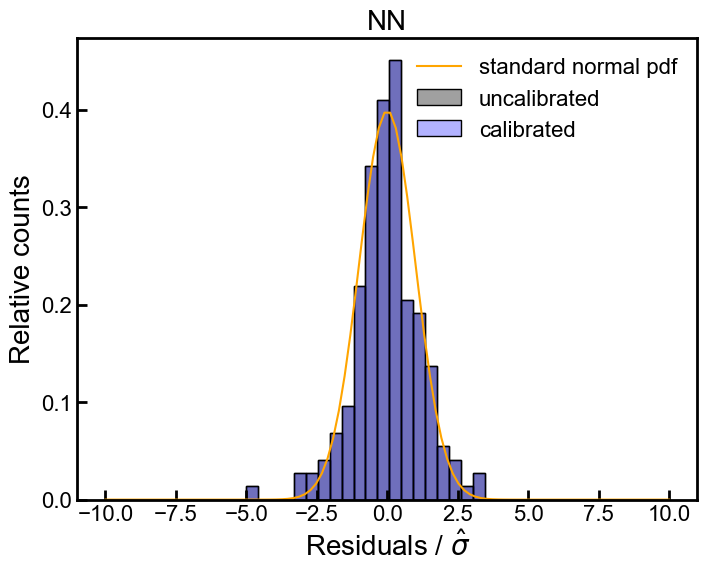

In [8]:
# pred_test, std_test, pred_train, std_train = NN(x_train, x_test, y_train, y_test)

# plt_true_vs_pred(y_train, y_test, pred_train, pred_test, std_train, std_test, savename='NN Creep Rupture Life', lim=(-1, 14))
# # print(type(pred_train))
# data = {'mean':list(pred_test)+list(pred_train),
#         'std':list(std_test)+list(std_train),
#         'true':list(y_test)+list(y_train) }
# result = pd.DataFrame(data)
# result_original = result
# # print(result)
# result.to_csv( 'result_NN.csv')

result = pd.read_csv('result_NN.csv')
result_original = result

result_test = result.iloc[:len(x_test), :]
result_train = result.iloc[len(x_test):, :]

# 训练集的数据
y_train = result_train['true']
pred_train = result_train['mean']
std_train = result_train['std']

# 测试集的数据
y_test = result_test['true']
pred_test = result_test['mean']
std_test = result_test['std']

# print(y_train.shape, pred_train.shape)
plt_true_vs_pred(y_train, y_test, pred_train, pred_test, std_train, std_test, savename='NN Creep Rupture Life', lim=(-1, 14))

print('cv:', cv(result))
print('scc:', scc(result))
# 生成校准图
plot_calibration_style(np.array(result['mean']),
                         np.array(result['std']), 
                         np.array(result['true']),
                       'NN_cal_original.png')
# 生成sharpness图
plot_sharpness_style(np.array(result['std']), 'NN_sharp_original.png')

rmse, rmv, ence = rmse_rmv(result)
print('ence:',ence)
# error_based(rmv, rmse, 'NN_original')

# 重校准后绘图
recalibrator = uct.recalibration.get_std_recalibrator(np.array(result['mean']),
                         np.array(result['std']), 
                         np.array(result['true']), criterion='rms_cal')
re_std = recalibrator(np.array(result['std']))
# # re_std = 0.55 * np.array(result['std'])
# # print(re_std)
result['std'] = re_std

plot_calibration_style(np.array(result['mean']),
                         re_std, 
                         np.array(result['true']),
                      'NN_recal.png')

plot_sharpness_style(re_std, 'NN_reshap.png')

# 打印结果
print('cv:', cv(result))
print('scc:', scc(result))

rmse_new, rmv_new, ence_new = rmse_rmv(result)
print('ence:',ence_new)
error_based(rmv, rmse, rmv_new, rmse_new, 'NN_re')
plot_residual_distribution(result_original, result, 'NN')